In [8]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as mpl

from scipy.stats import norm, moment

%matplotlib inline
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 16,6

# 10.1

Using the formulation in Section 10.3, plot the bet size ($m$) as a function of the maximum predicted probability ($\tilde p$) when $\lVert X \rVert = 2, 3, ..., 10$.

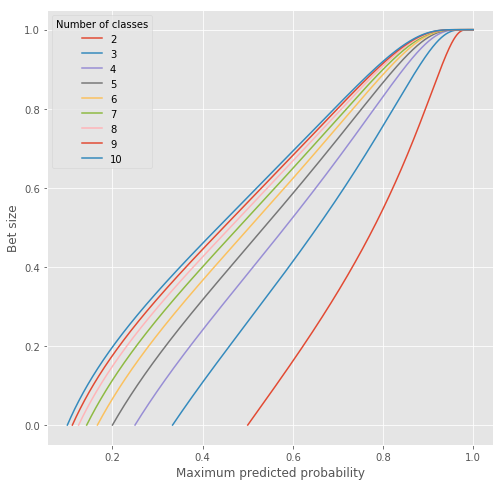

In [9]:
def bet_size_for_range(num_classes):
    prob = np.linspace(1 / num_classes, 1, 10000, endpoint=False)
    return pd.Series(bet_size(prob, num_classes), index=prob)

def bet_size(prob, num_classes):
    signal = (prob - 1 / num_classes) / (prob * (1 - prob)) ** 0.5
    return 2 * norm.cdf(signal) - 1

_, ax = mpl.subplots(figsize=(8, 8))
ax.set_xlabel("Maximum predicted probability")
ax.set_ylabel("Bet size")

for num_classes in range(2, 11):
    bs = bet_size_for_range(num_classes)
    ax.plot(bs, label=num_classes)

    ax.legend(title="Number of classes")


# 10.2.a

Draw 10,000 random numbers from a uniform distribution with bounds $U[.5, 1.]$.

Compute the bet sizes for $m$ for $\lVert X \rVert = 2$.

In [10]:
np.random.seed(42)
n_nums = 10000
nums1 = np.random.uniform(0.5, 1.0, n_nums)
nums1

array([0.68727006, 0.97535715, 0.86599697, ..., 0.97335396, 0.698744  ,
       0.6085702 ])

# 10.2.b

Draw 10,000 random numbers from a uniform distribution with bounds $U[.5, 1.]$.

Assign 10,000 consecutive calendar days to the bet sizes.

In [11]:
from datetime import datetime
days = [datetime.today() + pd.Timedelta(days=i) for i in range(n_nums)]

# 10.2.c

Draw 10,000 random numbers from a uniform distribution with bounds $U[1, 25]$.

In [12]:
nums2 = np.random.uniform(1, 25, n_nums)
nums2

array([ 9.96737964,  8.98989031,  5.2276939 , ...,  8.28876326,
       11.63968016,  5.13435554])

# 10.2.d

Form a pandas series indexed by the dates in 2.b, and with values equal to the index shifted forward by the number of days in 2.c. This is a `t1` object similar to the ones we used in Chapter 3. 

In [13]:
t1 = pd.Series([date + pd.Timedelta(days=days) for date, days in zip(days, nums2)], index=days)
t1.head()

2019-11-22 10:53:24.641289   2019-12-02 10:06:26.242462
2019-11-23 10:53:24.641289   2019-12-02 10:38:51.164034
2019-11-24 10:53:24.641289   2019-11-29 16:21:17.394255
2019-11-25 10:53:24.641289   2019-12-11 00:40:32.808411
2019-11-26 10:53:24.641289   2019-12-08 21:25:32.500520
dtype: datetime64[ns]

# 10.2.e

Compute the resulting active bets, following Section 10.4.

In [14]:
bet_size(nums1, 2)

array([0.31374524, 0.99783162, 0.71735212, ..., 0.99670976, 0.33511507,
       0.17603479])

In [15]:
from active_signals import avgActiveSignals
df0 = pd.DataFrame({'t1': t1, 'signal': bet_size(nums1, 2)})



In [16]:
active = avgActiveSignals(df0, 6)
active.head()

2019-11-22 10:53:37.816458 100.0% mpAvgActiveSignals done after 0.13 minutes. Remaining 0.0 minutes..


2019-11-22 10:53:24.641289    0.313745
2019-11-23 10:53:24.641289    0.655788
2019-11-24 10:53:24.641289    0.676310
2019-11-25 10:53:24.641289    0.643524
2019-11-26 10:53:24.641289    0.539921
dtype: float64

# 10.3.a

Using the `t1` object from exercise 2.d:

Determine the maximum number of concurrent long bets, $\bar c_l$.

In [17]:
df0 = pd.DataFrame({'t1': t1, 'signal': nums1})
df0['active_long'] = 0
df0['active_short'] = 0

# In order to make this example a bit more interesting we'll use p>= 0.75 for longs and the rest for shorts
cutoff = 0.75
for idx in df0.index:
    
    # A bet side greater than zero indicates a long position.
    df_long_active_idx = set(df0[(df0.index <= idx) & (df0['t1'] > idx) & (df0['signal'] >= cutoff)].index)
    df0.loc[idx, 'active_long'] = len(df_long_active_idx)
    # A bet side less than zero indicates a short position.
    df_short_active_idx = set(df0[(df0.index <= idx) & (df0['t1'] > idx) & (df0['signal'] < cutoff)].index)
    df0.loc[idx, 'active_short'] = len(df_short_active_idx)

    
df0.head()

,signal,t1,active_long,active_short
2019-11-22 10:53:24.641289,0.687270,2019-12-02 10:06:26.242462,0,1
2019-11-23 10:53:24.641289,0.975357,2019-12-02 10:38:51.164034,1,1
2019-11-24 10:53:24.641289,0.865997,2019-11-29 16:21:17.394255,2,1
2019-11-25 10:53:24.641289,0.799329,2019-12-11 00:40:32.808411,3,1
2019-11-26 10:53:24.641289,0.578009,2019-12-08 21:25:32.500520,3,2


In [18]:
active_long_max = df0['active_long'].max()

# 10.3.b

Using the `t1` object from exercise 2.d:

Determine the maximum number of concurrent short bets, $\bar c_s$.

In [19]:
active_short_max = df0['active_short'].max()

# 10.3.c

Using the `t1` object from exercise 2.d:

Derive the bet size as $m_t = c_{t,l} \frac{1}{c_l} -  c_{t,s} \frac{1}{c_s}$, where $c_{t,l}$ is the number of concurrent long bets at time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$.

In [20]:
active_long_max, active_short_max

(14, 15)

In [21]:
long_size = (df0['active_long'] / active_long_max).fillna(0)
short_size = (df0['active_short'] / active_short_max).fillna(0)

In [22]:
df0['new_b'] = long_size - short_size

In [23]:
df0.head()

,signal,t1,active_long,active_short,new_b
2019-11-22 10:53:24.641289,0.687270,2019-12-02 10:06:26.242462,0,1,-0.066667
2019-11-23 10:53:24.641289,0.975357,2019-12-02 10:38:51.164034,1,1,0.004762
2019-11-24 10:53:24.641289,0.865997,2019-11-29 16:21:17.394255,2,1,0.076190
2019-11-25 10:53:24.641289,0.799329,2019-12-11 00:40:32.808411,3,1,0.147619
2019-11-26 10:53:24.641289,0.578009,2019-12-08 21:25:32.500520,3,2,0.080952


# 10.4.a

Using the `t1` object from exercise 2.d:

Compute the series $c_t = c_{t,l} -  c_{t,s}$ where $c_{t,l}$ is the number of concurrent long bets at time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$.

# 10.4.b

Using the `t1` object from exercise 2.d:

Fit a mixture of two Gaussians on ${c_t}$. You may want to use the method described in Lopez de Prado and Foreman [2014].

# 10.4.c

Using the `t1` object from exercise 2.d:

Derive the bet size as $m_t =
\begin{cases}
  \frac{F[c_t]-F[0]}{1-F[0]} & \text{if}\ c_t \ge 0 \\
  \frac{F[c_t]-F[0]}{F[0]} & \text{if}\ c_t \lt 0
\end{cases}
 $ where $F [x]$ is the CDF of the fitted mixture of two Gaussians for a value $x$.

# 10.4.d

Using the `t1` object from exercise 2.d:

Explain how this series $\{m_t\}$ differs from the bet size series computed in exercise 3.

# 10.5

Repeat exercise 1, where you discretize $m$ with a `stepSize=0.01`, `stepSize=0.05` and `stepSize=0.1`.

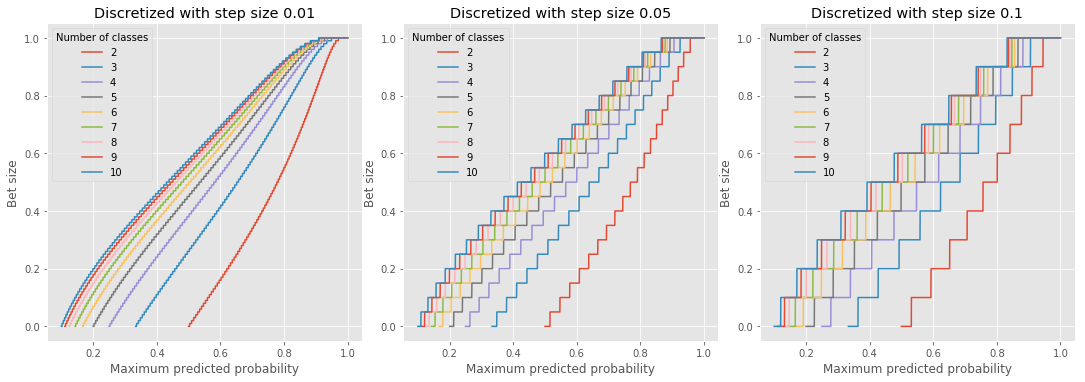

In [34]:
step_sizes = [0.01, 0.05, 0.1]
fig, axes = mpl.subplots(1, 3, figsize=(15, 5))
fig.tight_layout()

for step_size, ax in zip(step_sizes, axes):
    for num_classes in range(2, 11):
        bs = bet_size_for_range(num_classes)
        stepped = (bs / step_size).round() * step_size
        ax.plot(stepped, label=num_classes)

        ax.set_title("Discretized with step size %s" % step_size)
        ax.set_xlabel("Maximum predicted probability")
        ax.set_ylabel("Bet size")
        ax.legend(title="Number of classes")


# 10.6

Rewrite the equations in Section 10.6, so that the bet size is determined by a power function rather than a sigmoid function.

# 10.7

Modify Snippet 10.4 so that is implements the equations you derived in exercise 6.